In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.display import display
from geopy.geocoders import Nominatim
import datetime as dt


In [3]:
#place = input ("Enter Address :")
place = "408 brook pine trl, apex, nc"

In [4]:
geolocator = Nominatim(user_agent="Test")
location = geolocator.geocode(place)
location

Location(Brook Pine Trail, Town of Apex, Wake County, North Carolina, 27519-9443, United States, (35.7625474, -78.8912379, 0.0))

In [5]:
years = ['2016','2017','2018','2019']
df = []

lat, lon =  location.latitude, location.longitude
api_key = '5qyFRrBVjEZIGuR0WEcihqCEcg4LV8DbErgE6rze'
attributes = 'ghi'
leap_year = 'false'
interval = '30'
utc = 'false'
your_name = 'Anthony+N'
reason_for_use = 'testing'
your_affiliation = 'ECU'
your_email = 'natalea20@students.ecu.edu'
mailing_list = 'false'

for year in years:
    url = 'https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    df.append(pd.read_csv(url, skiprows=2))    

# Concatenate Multiple year data into one DataFrame
big_frame = pd.concat(df, ignore_index=True)


In [6]:
big_frame.head(5).append(big_frame.tail(5))

,Year,Month,Day,Hour,Minute,GHI
0,2016,1,1,0,0,0
1,2016,1,1,0,30,0
2,2016,1,1,1,0,0
3,2016,1,1,1,30,0
4,2016,1,1,2,0,0
70075,2019,12,31,21,30,0
70076,2019,12,31,22,0,0
70077,2019,12,31,22,30,0
70078,2019,12,31,23,0,0
70079,2019,12,31,23,30,0


In [7]:
# Set the time index in the pandas dataframe:
#big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2017), freq=interval+'Min', periods=52560 ))
big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2016), freq=interval+'Min', periods=70080))

# take a look
big_frame.shape

(70080, 6)

In [8]:
# filtering data 
big_frame=big_frame[(big_frame["GHI"]!=0)]

In [9]:
big_frame.reset_index(inplace=True)

In [10]:
#New DF with just Index & GHI
prophet_frame = big_frame[['index','GHI']]
prophet_frame.head()

,index,GHI
0,2016-01-01 08:00:00,42
1,2016-01-01 08:30:00,97
2,2016-01-01 09:00:00,155
3,2016-01-01 09:30:00,210
4,2016-01-01 10:00:00,260


In [11]:
#Renaming columns to ds & y
prophet_frame = prophet_frame.rename(columns = {'index':'ds','GHI':'y'})
prophet_frame['ds']=pd.to_datetime(prophet_frame.ds)

In [12]:
prophet_frame = prophet_frame.set_index(['ds'])

In [13]:
#Group by to get Monthly Values
prophet_frame_new = prophet_frame.groupby(prophet_frame.index.date).sum()
prophet_frame_new.reset_index(inplace=True)
prophet_frame_new = prophet_frame_new.rename(columns = {'index':'ds'})
prophet_frame_new['ds']=pd.to_datetime(prophet_frame_new.ds)

#Drop rows with null values
prophet_frame_new.dropna() 

,ds,y
0,2016-01-01,2856
1,2016-01-02,6704
2,2016-01-03,5227
3,2016-01-04,3073
4,2016-01-05,6998
...,...,...
1455,2019-12-26,4210
1456,2019-12-27,5133
1457,2019-12-28,2777
1458,2019-12-29,3967


<AxesSubplot:xlabel='ds'>

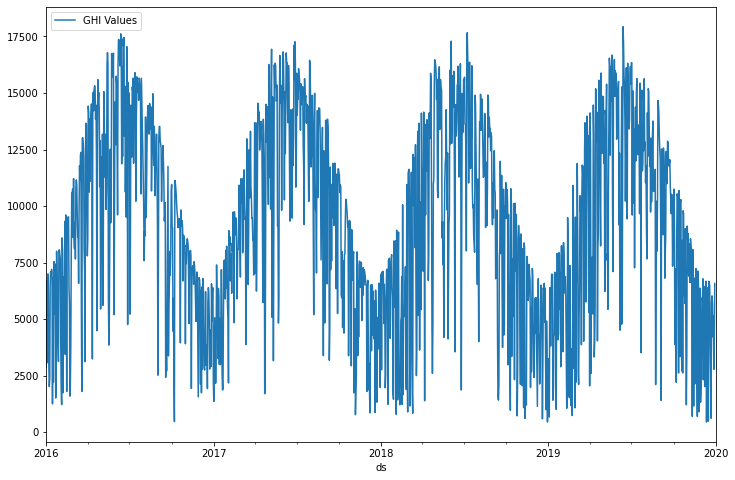

In [14]:
prophet_frame_new.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values',xlim=('2016-01-01','2020-01-01'))

In [31]:
# Pick model 3
m3 = Prophet(interval_width=0.85,changepoint_prior_scale=5,daily_seasonality=True,yearly_seasonality=20)
#For Graphs use below
#m3 = Prophet(interval_width=0.85,daily_seasonality=True,yearly_seasonality=20)
m3.add_seasonality(name='daily', period=365.25, fourier_order=5, prior_scale=0.02)
m3.fit(prophet_frame_new)

In [32]:
# Select the Period for future prediction
future3 = m3.make_future_dataframe(periods=730)
forecast3 = m3.predict(future3)

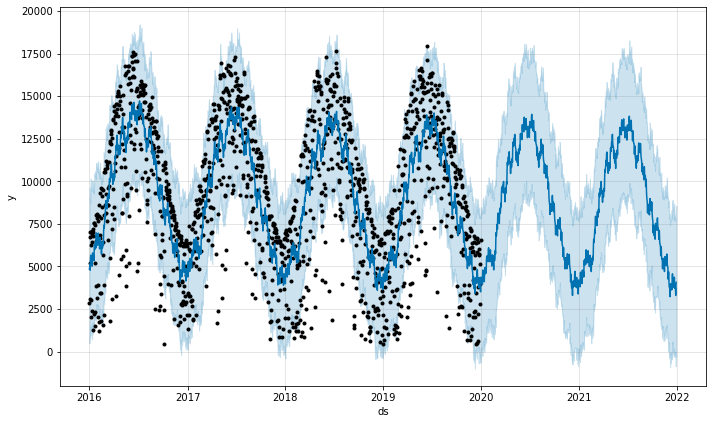

In [33]:
# Python
fig1 = m3.plot(forecast3)

In [34]:
dfprint3 = forecast3[["ds", "trend","yhat_lower", "yhat_upper", "yhat"]]
#dfprint.head(5).append(dfprint.tail(5))
pd.set_option('display.float_format', '{:.2f}'.format)
dfprint3 = forecast3[["ds",  "yhat"]]
dfprint3.groupby([dfprint3['ds'].dt.year.rename('year')]).agg({'sum'})

,yhat
,sum
year,
2016,3519967.35
2017,3404230.41
2018,3295014.84
2019,3242816.49
2020,3213526.84
2021,3168469.67


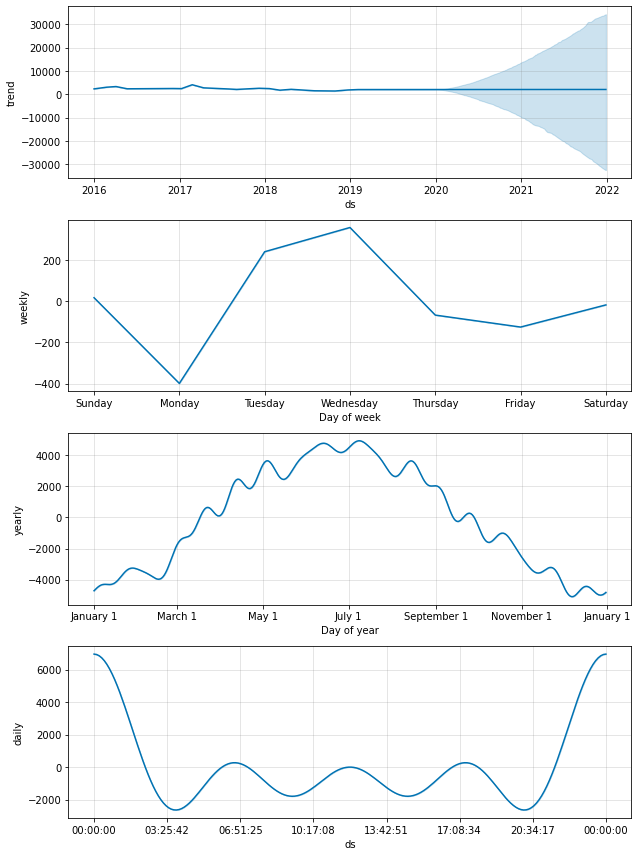

In [19]:
# Python
fig2 = m3.plot_components(forecast3)


In [21]:
# Python
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m3, forecast3)